## Notebook to fit triple orbits with astrometry + rv

In [174]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,binary_model_combined,astrometry_model_vlti,rv_model,rv_model_circular,triple_model,triple_model_circular,triple_model_combined,triple_model_vlti_combined,triple_model_vlti,triple_model_combined_circular,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *
import emcee
import corner
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [175]:
## setup paths for user
path = '/Users/tgardne/ARMADA_orbits'
path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
path_wds = '/Users/tgardne/ARMADA_orbits'
path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'

In [176]:
## Specify target
target_hd = '170756' ## HD number
note = 'combined' ## note for saved file
corrected = 'n' ## bootstrap errors?

In [177]:
query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

HIP 90697


In [178]:
#target_wds = '09320-0111'

In [179]:
###########################################
## Read in ARMADA data
###########################################
if corrected == 'y':
    print('reading boostrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))

weight_rv = 10 ## km/s error

t_rv,rv,err_rv = read_rv(file_rv,weight_rv)
t_rv-=2400000
file_rv.close()

reading chi2 errors


MJD? (y,[n]):  n


In [ ]:
## print rv for paper
for i,j in zip(t_rv,rv):
    print('& %s & %s & -- & -- & -- \\\\'%(i,j))

In [68]:
#t_rv = t_rv-2400000

In [180]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

Closest factor for 58567.4765 is 45.68537702833419 days away
Closest factor for 58568.4888 is 44.673077028332045 days away
Closest factor for 58641.3992 is 4.368803160665266 days away
Closest factor for 58708.2094 is 5.166458308893198 days away
Closest factor for 58709.2368 is 6.193858308892231 days away
Closest factor for 59059.2516 is 15.188757008472749 days away
Closest factor for 59060.2354 is 15.860067544977937 days away
Closest factor for 59061.1899 is 14.905567544978112 days away
Closest factor for 59412.2863 is 1.7603956367602223 days away
Closest factor for 59738.3842 is 183.78175162280968 days away
Closest factor for 59747.2839 is 192.68145162281144 days away
Closest factor for 59737.3599 is 182.75745162281237 days away
Closest factor for 59738.3826 is 183.78015162280644 days away
Closest factor for 59739.3642 is 184.76175162281288 days away
Closest factor for 59747.2857 is 192.68325162280962 days away
   date      etalon factor
58567.4765 1.0008064363133506
58568.4888 1.0008

In [181]:
## set etalon factors to 1 for vlti data
vlti = 'n'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
else:
    vlti_idx = []
    
## Apply etalon
etalon = 'n'
if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')

No etalon correction applied


In [182]:
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

vlti_mask = np.ones(len(t),dtype=bool)
vlti_mask[vlti_idx] = False

In [183]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'n'
if input_wds == 'y':
    file=open(os.path.expanduser("%s/HD%s_chi2err/HD_%s_wds.txt"%(path_wds,target_hd,target_hd)))
    weight = 1
    t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_data(file,weight)
    print('Number of WDS data points = %s'%len(p_wds))

    ## correct WDS for PA
    #theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    idx = np.argmin(t)

    plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
    plt.plot(xpos_wds[0],ypos_wds[0],'*')
    plt.plot(xpos[idx],ypos[idx],'*')
    if len(vlti_idx)>0:
        plt.plot(xpos[vlti_mask],ypos[vlti_mask],'+',label='ARMADA-CHARA')
        plt.plot(xpos[vlti_idx],ypos[vlti_idx],'+',label='ARMADA-VLTI')
    else:
        plt.plot(xpos,ypos,'+',label='ARMADA')
    plt.plot(0,0,'*')
    plt.gca().invert_xaxis()
    plt.title('All Data')
    plt.xlabel('dra (mas)')
    plt.ylabel('ddec (mas)')
    plt.legend()
    plt.show()

    flip = input('Flip WDS data? (y/n): ')
    if flip=='y':
        xpos_wds=-p_wds*np.sin(theta_wds)
        ypos_wds=-p_wds*np.cos(theta_wds)
        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        plt.plot(xpos[idx],ypos[idx],'*')
        plt.plot(xpos,ypos,'+',label='ARMADA')
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        better = input('Flip data back to original? (y/n): ')
        if better=='y':
            xpos_wds=p_wds*np.sin(theta_wds)
            ypos_wds=p_wds*np.cos(theta_wds)
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

NO WDS DATA


In [184]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6')
    
self_params = 'y'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))
    

--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
No elements found in ORB6


a (mas):  2
P (year):  3.3
ecc :  0.2
inc (deg):  135
omega (deg):  138
bigomega (deg):  347
T (mjd):  59044


In [185]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

vlti_mask_all = np.ones(len(t_all),dtype=bool)
vlti_mask_all[vlti_idx] = False

In [186]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(astrometry_model_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    resids_wds = astrometry_model(result.params,xpos_wds,ypos_wds,t_wds,error_maj_wds,
                                 error_min_wds,error_pa_wds)
    ndata_armada = 2*sum(~np.isnan(xpos))
    ndata_wds = 2*sum(~np.isnan(xpos_wds))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)
    print('chi2 wds = %s'%chi2_wds)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 30
    # variables        = 7
    chi-square         = 3.39045037
    reduced chi-square = 0.14741089
    Akaike info crit   = -51.4070385
    Bayesian info crit = -41.5986568
[[Variables]]
    w:           131.427095 +/- 4.52213727 (3.44%) (init = 138)
    bigw:        343.631693 +/- 2.98563260 (0.87%) (init = 347)
    inc:         136.177498 +/- 3.23204836 (2.37%) (init = 135)
    e:           0.20149674 +/- 0.00848925 (4.21%) (init = 0.2)
    a:           2.02955910 +/- 0.02691505 (1.33%) (init = 2)
    P:           1203.78861 +/- 9.34038467 (0.78%) (init = 1205.325)
    T:           59037.3368 +/- 6.40613734 (0.01%) (init = 59044)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, bigw)   =  0.933
    C(w, T)      =  0.793
    C(inc, P)    = -0.740
    C(P, T)      =  0.637
    C(w, P)      =  0.614
    C(inc, e)    =  0.599
    C(bigw, in

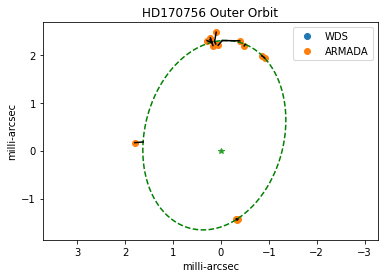

In [187]:
###########################################
## Do a least-squares fit -- VISUAL ONLY
###########################################
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

In [188]:
## scale errors to fit again
chara_scale = 1/np.sqrt(0.15)
vlti_scale = 1
wds_scale = 1/np.sqrt(1)

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(xpos):]/=wds_scale
    error_min_all[len(xpos):]/=wds_scale
    
else:
    error_maj/=chara_scale
    error_min/=chara_scale
    error_maj_all[:len(error_maj)]/=chara_scale
    error_min_all[:len(error_maj)]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(xpos):]/=wds_scale
    error_min_all[len(xpos):]/=wds_scale

----------
chi2 armada = 0.982739238334035
----------


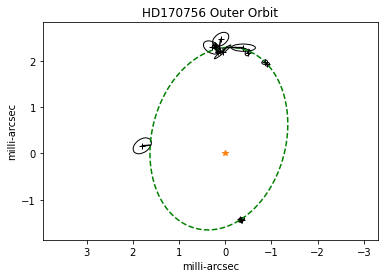

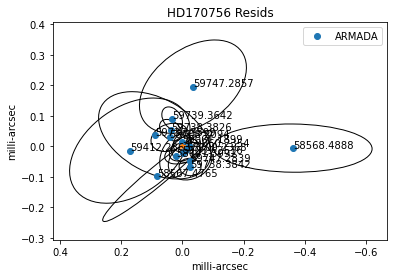

----------
Mean residual = 65.4 micro-as
----------


In [189]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if corrected == 'y':
    directory='%s/HD%s_bootstrap_triple/'%(path,target_hd)
else:
    directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'+', label='ARMADA',color='black',markersize=6)
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xpos,ypos,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    #ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

## Include RV

In [56]:
## randomize orbital elements:
guess_params = 'y'
if guess_params=='y':

    astart = 2
    aend = 3
    Pstart = 3*365
    Pend = 3.6*365

    w_results = []
    bigw_results = []
    inc_results = []
    e_results = []
    a_results = []
    P_results = []
    T_results = []
    mirc_scale_results = []
    chi2_results = []
    K_results = []
    gamma_results = []

    for s in tqdm(np.arange(50)):
        x1 = random.uniform(0,360)
        x2 = random.uniform(0,360)
        x3 = random.uniform(0,180)
        x4 = random.uniform(0,0.9)
        x5 = random.uniform(astart,aend)
        x6 = random.uniform(Pstart,Pend)
        #x7 = random.uniform(30000,80000)
        x7 = random.uniform(58500,59100)
        
        x8 = random.uniform(-30,30)
        x9 = random.uniform(-30,30)

        params = Parameters()
        params.add('w',   value= x1, min=0, max=360)
        params.add('bigw', value= x2, min=0, max=360)
        params.add('inc', value= x3, min=0, max=180)
        params.add('e', value= x4, min=0, max=0.99)
        params.add('a', value= x5, min=0)
        params.add('P', value= x6, min=0)
        params.add('T', value= x7, min=0)
        params.add('K', value= x8)
        params.add('gamma', value= x9)
        if len(vlti_idx)>0:
            params.add('mirc_scale', value=1)
        else:
            params.add('mirc_scale',value=1,vary=False)

        #do fit, minimizer uses LM for least square fitting of model to data
        minner = Minimizer(binary_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                    error_maj_all,error_min_all,
                                                    error_pa_all,rv,t_rv,err_rv),
                    nan_policy='omit')
        result = minner.minimize()

        w_results.append(result.params['w'].value)
        bigw_results.append(result.params['bigw'].value)
        inc_results.append(result.params['inc'].value)
        e_results.append(result.params['e'].value)
        a_results.append(result.params['a'].value)
        P_results.append(result.params['P'].value)
        T_results.append(result.params['T'].value)
        mirc_scale_results.append(result.params['mirc_scale'].value)
        chi2_results.append(result.redchi)
        gamma_results.append(result.params['gamma'].value)
        K_results.append(result.params['K'].value)

    w_results = np.array(w_results)
    bigw_results = np.array(bigw_results)
    inc_results = np.array(inc_results)
    e_results = np.array(e_results)
    a_results = np.array(a_results)
    P_results = np.array(P_results)
    T_results = np.array(T_results)
    mirc_scale_results = np.array(mirc_scale_results)
    chi2_results = np.array(chi2_results)
    gamma_results = np.array(gamma_results)
    K_results = np.array(K_results)

    idx = np.argmin(chi2_results)
    w_start = w_results[idx]
    bigw_start = bigw_results[idx]
    inc_start = inc_results[idx]
    e_start = e_results[idx]
    a_start = a_results[idx]
    P_start = P_results[idx]
    T_start = T_results[idx]
    gamma_start = gamma_results[idx]
    K_start = K_results[idx]
    mirc_scale_start = mirc_scale_results[idx]

    print('P, a, e, inc, w, bigw, T, K, gamma, mirc_scale: ')
    print(P/365, a_start, e_start, inc_start, w_start, bigw_start, T_start, K_start, gamma_start, mirc_scale_start)

100%|██████████| 50/50 [09:42<00:00, 11.64s/it]

P, a, e, inc, w, bigw, T, K, gamma, mirc_scale: 
3.302260273972603 2.130109199141757 0.17349136534875084 135.02910101596177 294.82449986466264 156.70870419434303 59014.56317788837 10.788430855380135 -29.86634904976528 1


In [190]:
###########################################
## Do a least-squares fit -- VISUAL ONLY
###########################################
params = Parameters()

#params.add('w',   value= w_start, min=0, max=360)
#params.add('bigw', value= bigw_start, min=0, max=360)
#params.add('inc', value= inc_start, min=0, max=180)
#params.add('e', value= e_start, min=0, max=0.99)
#params.add('a', value= a_start, min=0)
#params.add('P', value= P_start, min=0)
#params.add('T', value= T_start, min=0)

params.add('w',   value= 123, min=0, max=360)
params.add('bigw', value= 340-180, min=0, max=360)
params.add('inc', value= 137, min=0, max=180)
params.add('e', value= 0.2, min=0, max=0.99)
params.add('a', value= 2.04, min=0)
params.add('P', value= 1192, min=0)
params.add('T', value= 59029, min=0)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

params.add('K',value=11)
params.add('gamma',value=-30)

In [191]:
minner = Minimizer(binary_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                    error_maj_all,error_min_all,
                                                    error_pa_all,rv,t_rv,err_rv),
                    nan_policy='omit')
result = minner.minimize()
report_fit(result)
    
P_best = result.params['P'].value
a_best = result.params['a'].value
e_best = result.params['e'].value
w_best = result.params['w'].value
bigw_best = result.params['bigw'].value
inc_best = result.params['inc'].value
T_best = result.params['T'].value
K_best = result.params['K'].value
gamma_best = result.params['gamma'].value
mirc_scale_best = result.params['mirc_scale'].value

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 309
    # variables        = 9
    chi-square         = 5331.18102
    reduced chi-square = 17.7706034
    Akaike info crit   = 898.027920
    Bayesian info crit = 931.627991
[[Variables]]
    w:           112.670501 +/- 7.35678784 (6.53%) (init = 123)
    bigw:        157.644164 +/- 4.55735129 (2.89%) (init = 160)
    inc:         132.641712 +/- 7.38590183 (5.57%) (init = 137)
    e:           0.15920055 +/- 0.03167954 (19.90%) (init = 0.2)
    a:           2.15967674 +/- 0.09171143 (4.25%) (init = 2.04)
    P:           1188.43420 +/- 4.17131298 (0.35%) (init = 1192)
    T:           59008.0669 +/- 21.8591487 (0.04%) (init = 59029)
    mirc_scale:  1 (fixed)
    K:           10.8609124 +/- 0.76030970 (7.00%) (init = 11)
    gamma:      -29.8750354 +/- 0.40718225 (1.36%) (init = -30)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, T)      =  0.902
    C(inc, a)    =

----------
chi2 armada = 5546.303696947893
----------


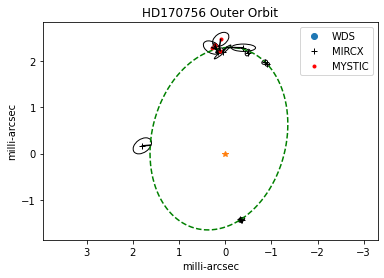

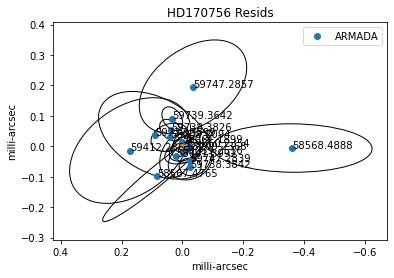

----------
Mean residual = 65.4 micro-as
----------


In [192]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos[:10],ypos[:10],'+', label='MIRCX',color='black')
    ax.plot(xpos[10:],ypos[10:],'.', label='MYSTIC',color='red')
    #ax.plot(xpos[-1],ypos[-1],'o', label='GRAVITY',color='blue')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xpos,ypos,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    #ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_best,a_best,e_best,
                                   inc_best*180/np.pi,w_best*180/np.pi,
                                   bigw_best*180/np.pi,T_best,
                                  mirc_scale_best,resids_median))
f.close()

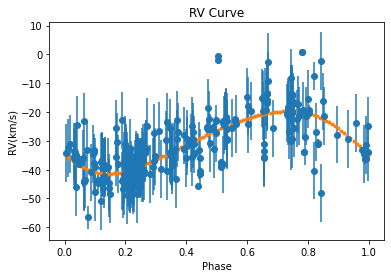

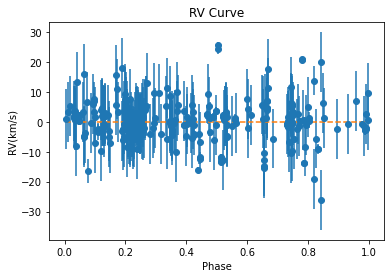

In [193]:
#Plot RV results:
w_rv = w_best*np.pi/180#+np.pi
foldtime= foldAt(t_rv,P_best,T0=T_best)
tt=np.linspace(T_best,T_best+P_best,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
MM2=[]
for i in t_rv:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM2.append(mm_anom)
MM2=np.asarray(MM2)
EE2=[]

for j in MM2:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE2.append(ee_anom)
EE2=np.asarray(EE2)

f=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE/2))
y1=K_best*(np.cos(w_rv+f)+e_best*np.cos(w_rv))+gamma_best
tt_fold=foldAt(tt,P_best,T0=T_best)

fpoints=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE2/2))
y1points=K_best*(np.cos(w_rv+fpoints)+e_best*np.cos(w_rv))+gamma_best

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'.')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

plt.errorbar(foldtime,rv-y1points,yerr=err_rv,fmt='o')
plt.plot([0,1],[0,0],'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_resids_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [28]:
resids = rv-y1points

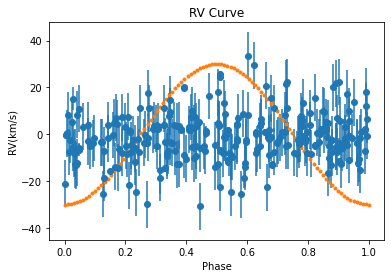

In [29]:
#Plot RV results:
w_rv = 0*np.pi/180+np.pi
foldtime= foldAt(t_rv,4.6,T0=58576.99)
tt=np.linspace(58576.99,58576.99+4.6,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/4.6*(i-58576.99)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,0)
    EE.append(ee_anom)
EE=np.asarray(EE)
MM2=[]
for i in t_rv:
    mm_anom=2*np.pi/4.6*(i-58576.99)
    MM2.append(mm_anom)
MM2=np.asarray(MM2)
EE2=[]

for j in MM2:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,0)
    EE2.append(ee_anom)
EE2=np.asarray(EE2)

f=2*np.arctan(np.sqrt((1+0)/(1-0))*np.tan(EE/2))
y1=30*(np.cos(w_rv+f)+0*np.cos(w_rv))+0
tt_fold=foldAt(tt,4.6,T0=58576.99)

fpoints=2*np.arctan(np.sqrt((1+0)/(1-0))*np.tan(EE2/2))
y1points=30*(np.cos(w_rv+fpoints)+0*np.cos(w_rv))+0

plt.errorbar(foldtime,resids,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'.')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
#plt.savefig('%s/HD%s_%s_orbit_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## Mass / Orbit Information

a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

K_err = ufloat(result.params['K'].value,result.params['K'].stderr)
gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

## distance from HIP/GAIA
## AC Her
plx_hip = ufloat(0.00053,0.00140)
plx_gaia = ufloat(0.0005887,0.0000338)


print('Distance from HIP = ')
print(1/plx_hip)
print('Distance from GAIA = ')
print(1/plx_gaia)

d_err = 1/plx_gaia
#d_err = d_rv

In [ ]:
print('%s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P_err.nominal_value,a_err.nominal_value,
                                               e_err.nominal_value,inc_err.nominal_value,
                                               w_err.nominal_value,bigw_err.nominal_value,
                                               T_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P_err.std_dev,a_err.std_dev,
                                                                                  e_err.std_dev,inc_err.std_dev,w_err.std_dev,
                                                                                  bigw_err.std_dev,T_err.std_dev,))
print('--'*10)

if include_rv=='y':
    print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                             e2_err.nominal_value,inc2_err.nominal_value,
                                                             w2_err.nominal_value,bigw2_err.nominal_value,
                                                             T2_err.nominal_value,K_err.nominal_value,
                                                             gamma_err.nominal_value))
    print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P2_err.std_dev,
                                                                                                          a2_err.std_dev,e2_err.std_dev,
                                                                                                          inc2_err.std_dev,w2_err.std_dev,
                                                                                                          bigw2_err.std_dev,T2_err.std_dev,
                                                                                                          K_err.std_dev,gamma_err.std_dev,))
else:
    print('%s & %s & %s & %s & %s & %s & %s & %s & -- & --'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                             e2_err.nominal_value,inc2_err.nominal_value,
                                                             w2_err.nominal_value,bigw2_err.nominal_value,
                                                             T2_err.nominal_value))
    print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & & '%(P2_err.std_dev,
                                                                                                          a2_err.std_dev,e2_err.std_dev,
                                                                                                          inc2_err.std_dev,w2_err.std_dev,
                                                                                                          bigw2_err.std_dev,T2_err.std_dev))

In [ ]:
d_err = 1/plx_gaia
#d_err = d_rv

print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2 = %s Msun'%sum1)

In [ ]:
semi = a_err/1000*d_err
print('semi = %s au'%semi)